In [2]:
import numpy as np
import math
import random
import time

def Generate_Quire_Set(d,qnum=50):
    """ d:维数 qnum:查询点数量 """
    return np.random.uniform(-50,50,size=(qnum,d))
    
def Generate_Data_Set(d,c,R,n):
    """ d:维数  n:数据量  c=1+ε"""
    quires=Generate_Quire_Set(d)
    temp=int(math.ceil(n/len(quires)))
    data=np.empty(shape=[0, d])
    for q in quires:
        for i in range(temp):
            di_temp=list()
            flag1=np.random.randint(0,d)
            for di in range(d):
                if i>=0 and i<=10:
                    di=random.uniform(q[di]-R/d,q[di]+R/d)
                else:
                    if(flag1==di):
                        flag2=np.random.randint(0,2)
                        if flag2==0:
                            di=random.uniform(q[di]+c*R,50)
                        else:
                            di=random.uniform(-50,q[di]-c*R)
                    else:
                        di=random.uniform(-50,50)
                di_temp.append(di)
            data=np.insert(data,i,di_temp,axis=0)
    np.save('E2LSH_Quires',quires)
    np.save('E2LSH_DataSet',data)
    return

Generate_Data_Set(20,2,1,100000)

[0.616, 0.801, 0.889, 0.947, 0.971, 0.984, 0.9875]
[32, 64, 96, 128, 160, 192, 224]


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:189: RankWarning: Polyfit may be poorly conditioned


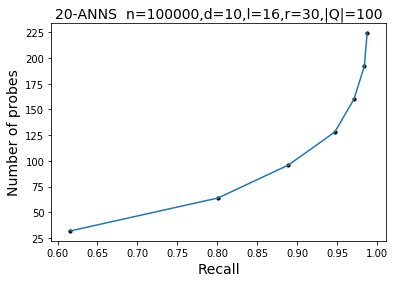

In [2]:
import numpy as np
import math
import random
import heapq
import time
import matplotlib.pyplot as plt




def kClosestSort(points,k,origin):
    """返回离点origin在L1范式下欧几里得空间距离最靠近的k个点（堆排序） 时间复杂度Θ(nlogn)"""
    return heapq.nsmallest(k, points, lambda p:E2Distance(p,origin) )

def E2LSH_Init(L,k,r=30):
    """ k:线段编号长度  L:哈希表的数量(实线数量) r:线段长度 """
    data=np.load('E2LSH_DataSet.npy')
    n=data.shape[0]
    d=data.shape[1]
    hashtable=dict()
    for i in range(L):
        a_values=np.random.normal(0,1,size=(k,d))
        b_values=np.random.uniform(0,r,k)
        hashtable[i]=(a_values,b_values)
        #hashtable[i]=a_values
    hashtable=np.load('HashFunction_l='+str(L)+'.npy').item()
    lines=dict()
    for i in range(L):
        line=dict()
        for j in range(n):
            hashcode=list()
            for v in range(k):
                code=int(math.floor((np.inner(hashtable[i][0][v],data[j])+hashtable[i][1][v])/r))
                #code=int(math.floor((np.inner(hashtable[i][0][v],data[j]))/r))
                hashcode.append(code)
            hashcode=tuple(hashcode)
            if hashcode not in line.keys():
                line[hashcode]=set()
            line[hashcode].add(tuple(data[j]))
        lines[i]=line
    #np.save('HashFunction_l='+str(L)+'_k='+str(k),hashtable)    
    return lines

def E2LSH_Inquire1(L,lines,r=30,K=20):
    quires=np.load('E2LSH_Quires.npy')
    hashtable=np.load('HashFunction_l='+str(L)+'.npy').item()
    L=len(hashtable)
    k=len(hashtable[0][0])
    #k=len(hashtable[0])
    qnum=len(quires)
    result=dict()
    for q in range(qnum):
        S=set()
        for i in range(L):
            hashcode=list()
            for j in range(k):
                code=int(math.floor((np.inner(hashtable[i][0][j],quires[q])+hashtable[i][1][j])/r))
                #code=int(math.floor((np.inner(hashtable[i][0][j],quires[q]))/r))
                hashcode.append(code)
            hashcode=tuple(hashcode)
            if hashcode in lines[i].keys():
                S=S|lines[i][hashcode]
        S=list(S)
        SK=list()
        if len(S)>K:
            SK=kClosestSort(S,K,quires[q])
        else:
            SK=S
        result[q]=SK
    return result


def PowerSetsBinary(items):
    N = len(items)
    subsets=list()
    for i in range(2 ** N):#子集的个数
        subset = []
        for j in range(N):#用来判断二进制数的下标为j的位置的数是否为1
            if (i >> j) % 2:
                subset.append(items[j])
        subsets.append(subset)
    return subsets
      
def Step_Wise(hashcode,n):
    hashcodes=list()
    M=len(hashcode)
    subsets=PowerSetsBinary(list(range(M)))
    for i in range(1,n+1):
        for subset in subsets:
            if len(subset)==i:
                code=hashcode[:]
                k=1
                x=dict()
                x[1]=0
                while k>=1:
                    while x[k]<2:
                        x[k]+=1
                        if x[k]==1:
                            code[subset[k-1]]-=1
                        if x[k]==2:
                            code[subset[k-1]]+=1    
                        if k==i:
                            hashcodes.append(tuple(code))
                            if x[k]==1:
                                code[subset[k-1]]+=1
                            if x[k]==2:
                                code[subset[k-1]]-=1
                        else:
                            k+=1
                            x[k]=0
                    k-=1
                    if k>=1 and x[k]==1:
                        code[subset[k-1]]+=1
                    if k>=1 and x[k]==2:
                        code[subset[k-1]]-=1
    return hashcodes

def E2LSH_Inquire2(L,lines,T,r=30,K=20):
    quires=np.load('E2LSH_Quires.npy')
    hashtable=np.load('HashFunction_l='+str(L)+'.npy').item()
    L=len(hashtable)
    k=len(hashtable[0][0])
    #k=len(hashtable[0])
    qnum=len(quires)
    result=dict()
    for q in range(qnum):
        S=set()
        for i in range(L):
            hashcodes=list()
            hashcode=list()
            for j in range(k):
                code=int(math.floor((np.inner(hashtable[i][0][j],quires[q])+hashtable[i][1][j])/r))
                #code=int(math.floor((np.inner(hashtable[i][0][j],quires[q]))/r))
                hashcode.append(code)
            hashcodes.append(tuple(hashcode))
            hashcodes.extend(Step_Wise(hashcode,5)[:T])
            for hashcode in hashcodes:
                if hashcode in lines[i].keys():
                    S=S|lines[i][hashcode]
        S=list(S)
        SK=list()
        if len(S)>K:
            SK=kClosestSort(S,K,quires[q])
        else:
            SK=S
        result[q]=SK
    return result,T*L


def Brute_ForceLinearSearch(K=20):
    """线性暴力搜索k近点"""
    data=np.load('E2LSH_DataSet.npy')
    quires=np.load('E2LSH_Quires.npy')
    data_temp=data.tolist()
    data=list()
    for i in data_temp:
        data.append(tuple(i))
    qnum=len(quires)
    real=dict()
    for q in range(qnum):
        q_real=kClosestSort(data,K,quires[q])
        real[q]=q_real
    return real

def Recall(result,real):
    quires=np.load('E2LSH_Quires.npy')
    qnum=len(real)
    temp1=0
    temp2=0
    for q in range(qnum):
        K=len(real[q])
        kdis=E2Distance(quires[q],real[q][len(real[q])-1])
        for point in result[q]:
            if E2Distance(quires[q],point)<=kdis:
                temp1+=1
        #temp1+=len(list(set(result[q]).intersection(set(real[q]))))
        temp2+=K
    recall=temp1/temp2
    return recall

def plot_trendline(x, y, n):
    plt.title("20-ANNS  n=100000,d=10,l=16,r=30,|Q|=100", fontsize=14)
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Number of probes", fontsize=14)
    plt.scatter(x, y,c='k',s=10)
    parameter = np.polyfit(x, y, n) # n=1为一次函数，返回函数参数
    f = np.poly1d(parameter) # 拼接方程
    plt.plot(x, f(x))
    #plt.axis([0, 1.1, 1, 128])
    plt.savefig('777.png', bbox_inches='tight')
    return

temp=list()
T=list()
real=Brute_ForceLinearSearch()
for i in range (1,8):
    lines=E2LSH_Init(8,3)
    result,probesum=E2LSH_Inquire2(8,lines,4*i)
    recall=Recall(result,real)
    temp.append(recall)
    T.append(probesum)
print(temp)
print(T)
plot_trendline(temp,T,7)